![alt text](ames_iowa_downtown.avif "Ames downtown city")

The aim of the followinng project is to predict house sale prices in Ames town, Iowa, USA. Ames is a typical small provincial american town with a population around 66 thousand (according to the 2020 census). This example might be generalized to other small towns in the United States, especially in Iowa. However, the main reason why this notebook was ever created is to present the typical Data Science workflow when dealing with regression predictive type of problem.

# Presets

In [1]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import plotly.figure_factory as ff
import matplotlib.pyplot as plt

#from sklearn.model_selection import train_test_split
#from sklearn import metrics

# Hyperparams tuning
#from sklearn.model_selection import GridSearchCV, ParameterGrid
#from sklearn_genetic import GASearchCV
#from sklearn_genetic.space import Continuous, Categorical, Integer

np.random.seed(42)

In [2]:
pd.set_option('display.max_columns', 500)

In [3]:
data = pd.read_csv('train.csv')

# Basic statistics

In [4]:
data.head()

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,LotConfig,LandSlope,Neighborhood,Condition1,Condition2,BldgType,HouseStyle,OverallQual,OverallCond,YearBuilt,YearRemodAdd,RoofStyle,RoofMatl,Exterior1st,Exterior2nd,MasVnrType,MasVnrArea,ExterQual,ExterCond,Foundation,BsmtQual,BsmtCond,BsmtExposure,BsmtFinType1,BsmtFinSF1,BsmtFinType2,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,Heating,HeatingQC,CentralAir,Electrical,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,KitchenQual,TotRmsAbvGrd,Functional,Fireplaces,FireplaceQu,GarageType,GarageYrBlt,GarageFinish,GarageCars,GarageArea,GarageQual,GarageCond,PavedDrive,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition,SalePrice
0,1,60,RL,65.0,8450,Pave,NaN,Reg,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2003,2003,Gable,CompShg,VinylSd,VinylSd,BrkFace,196.0,Gd,TA,PConc,Gd,TA,No,GLQ,706,Unf,0,150,856,GasA,Ex,Y,SBrkr,856,854,0,1710,1,0,2,1,3,1,Gd,8,Typ,0,NaN,Attchd,2003.0,RFn,2,548,TA,TA,Y,0,61,0,0,0,0,NaN,NaN,NaN,0,2,2008,WD,Normal,208500
1,2,20,RL,80.0,9600,Pave,NaN,Reg,Lvl,AllPub,FR2,Gtl,Veenker,Feedr,Norm,1Fam,1Story,6,8,1976,1976,Gable,CompShg,MetalSd,MetalSd,None,0.0,TA,TA,CBlock,Gd,TA,Gd,ALQ,978,Unf,0,284,1262,GasA,Ex,Y,SBrkr,1262,0,0,1262,0,1,2,0,3,1,TA,6,Typ,1,TA,Attchd,1976.0,RFn,2,460,TA,TA,Y,298,0,0,0,0,0,NaN,NaN,NaN,0,5,2007,WD,Normal,181500
2,3,60,RL,68.0,11250,Pave,NaN,IR1,Lvl,AllPub,Inside,Gtl,CollgCr,Norm,Norm,1Fam,2Story,7,5,2001,2002,Gable,CompShg,VinylSd,VinylSd,BrkFace,162.0,Gd,TA,PConc,Gd,TA,Mn,GLQ,486,Unf,0,434,920,GasA,Ex,Y,SBrkr,920,866,0,1786,1,0,2,1,3,1,Gd,6,Typ,1,TA,Attchd,2001.0,RFn,2,608,TA,TA,Y,0,42,0,0,0,0,NaN,NaN,NaN,0,9,2008,WD,Normal,223500
3,4,70,RL,60.0,9550,Pave,NaN,IR1,Lvl,AllPub,Corner,Gtl,Crawfor,Norm,Norm,1Fam,2Story,7,5,1915,1970,Gable,CompShg,Wd Sdng,Wd Shng,None,0.0,TA,TA,BrkTil,TA,Gd,No,ALQ,216,Unf,0,540,756,GasA,Gd,Y,SBrkr,961,756,0,1717,1,0,1,0,3,1,Gd,7,Typ,1,Gd,Detchd,1998.0,Unf,3,642,TA,TA,Y,0,35,272,0,0,0,NaN,NaN,NaN,0,2,2006,WD,Abnorml,140000
4,5,60,RL,84.0,14260,Pave,NaN,IR1,Lvl,AllPub,FR2,Gtl,NoRidge,Norm,Norm,1Fam,2Story,8,5,2000,2000,Gable,CompShg,VinylSd,VinylSd,BrkFace,350.0,Gd,TA,PConc,Gd,TA,Av,GLQ,655,Unf,0,490,1145,GasA,Ex,Y,SBrkr,1145,1053,0,2198,1,0,2,1,4,1,Gd,9,Typ,1,TA,Attchd,2000.0,RFn,3,836,TA,TA,Y,192,84,0,0,0,0,NaN,NaN,NaN,0,12,2008,WD,Normal,250000


In [5]:
print('Nrows:', data.shape[0])
print('Ncols:', data.shape[0])
print('rows/cols ratio:', data.shape[0]/data.shape[1])

Nrows: 1460
Ncols: 1460
rows/cols ratio: 18.02469135802469


- Rows/cols ratio seems to be pretty small, taking into consideration the fact that lot of variables are of type 'object'. Thus, dimensionality reduction must be held for sure

In [6]:
print(data.dtypes.to_string())

Id                 int64
MSSubClass         int64
MSZoning          object
LotFrontage      float64
LotArea            int64
Street            object
Alley             object
LotShape          object
LandContour       object
Utilities         object
LotConfig         object
LandSlope         object
Neighborhood      object
Condition1        object
Condition2        object
BldgType          object
HouseStyle        object
OverallQual        int64
OverallCond        int64
YearBuilt          int64
YearRemodAdd       int64
RoofStyle         object
RoofMatl          object
Exterior1st       object
Exterior2nd       object
MasVnrType        object
MasVnrArea       float64
ExterQual         object
ExterCond         object
Foundation        object
BsmtQual          object
BsmtCond          object
BsmtExposure      object
BsmtFinType1      object
BsmtFinSF1         int64
BsmtFinType2      object
BsmtFinSF2         int64
BsmtUnfSF          int64
TotalBsmtSF        int64
Heating           object


In [7]:
print('Number of integer columns:', len(data.dtypes[data.dtypes == 'int64']))
print('Number of float columns:', len(data.dtypes[data.dtypes == 'float64']))
print('Number of string columns:', len(data.dtypes[data.dtypes == 'object']))

Number of integer columns: 35
Number of float columns: 3
Number of string columns: 43


In [8]:
print(data.isna().sum().to_string())

Id                  0
MSSubClass          0
MSZoning            0
LotFrontage       259
LotArea             0
Street              0
Alley            1369
LotShape            0
LandContour         0
Utilities           0
LotConfig           0
LandSlope           0
Neighborhood        0
Condition1          0
Condition2          0
BldgType            0
HouseStyle          0
OverallQual         0
OverallCond         0
YearBuilt           0
YearRemodAdd        0
RoofStyle           0
RoofMatl            0
Exterior1st         0
Exterior2nd         0
MasVnrType          8
MasVnrArea          8
ExterQual           0
ExterCond           0
Foundation          0
BsmtQual           37
BsmtCond           37
BsmtExposure       38
BsmtFinType1       37
BsmtFinSF1          0
BsmtFinType2       38
BsmtFinSF2          0
BsmtUnfSF           0
TotalBsmtSF         0
Heating             0
HeatingQC           0
CentralAir          0
Electrical          1
1stFlrSF            0
2ndFlrSF            0
LowQualFin

- MiscFeature is totally absent?
- PoolQC, FireplaceQu, Alley, Fence may be absent rather due to natural reasons (just no fireplaces, pools in the house)
- Others must be ivestigated more throughly

In [9]:
data.describe()

,Id,MSSubClass,LotFrontage,LotArea,OverallQual,OverallCond,YearBuilt,YearRemodAdd,MasVnrArea,BsmtFinSF1,BsmtFinSF2,BsmtUnfSF,TotalBsmtSF,1stFlrSF,2ndFlrSF,LowQualFinSF,GrLivArea,BsmtFullBath,BsmtHalfBath,FullBath,HalfBath,BedroomAbvGr,KitchenAbvGr,TotRmsAbvGrd,Fireplaces,GarageYrBlt,GarageCars,GarageArea,WoodDeckSF,OpenPorchSF,EnclosedPorch,3SsnPorch,ScreenPorch,PoolArea,MiscVal,MoSold,YrSold,SalePrice
count,1460.000000,1460.000000,1201.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1452.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1379.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000,1460.000000
mean,730.500000,56.897260,70.049958,10516.828082,6.099315,5.575342,1971.267808,1984.865753,103.685262,443.639726,46.549315,567.240411,1057.429452,1162.626712,346.992466,5.844521,1515.463699,0.425342,0.057534,1.565068,0.382877,2.866438,1.046575,6.517808,0.613014,1978.506164,1.767123,472.980137,94.244521,46.660274,21.954110,3.409589,15.060959,2.758904,43.489041,6.321918,2007.815753,180921.195890
std,421.610009,42.300571,24.284752,9981.264932,1.382997,1.112799,30.202904,20.645407,181.066207,456.098091,161.319273,441.866955,438.705324,386.587738,436.528436,48.623081,525.480383,0.518911,0.238753,0.550916,0.502885,0.815778,0.220338,1.625393,0.644666,24.689725,0.747315,213.804841,125.338794,66.256028,61.119149,29.317331,55.757415,40.177307,496.123024,2.703626,1.328095,79442.502883
min,1.000000,20.000000,21.000000,1300.000000,1.000000,1.000000,1872.000000,1950.000000,0.000000,0.000000,0.000000,0.000000,0.000000,334.000000,0.000000,0.000000,334.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,0.000000,1900.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,2006.000000,34900.000000
25%,365.750000,20.000000,59.000000,7553.500000,5.000000,5.000000,1954.000000,1967.000000,0.000000,0.000000,0.000000,223.000000,795.750000,882.000000,0.000000,0.000000,1129.500000,0.000000,0.000000,1.000000,0.000000,2.000000,1.000000,5.000000,0.000000,1961.000000,1.000000,334.500000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,5.000000,2007.000000,129975.000000
50%,730.500000,50.000000,69.000000,9478.500000,6.000000,5.000000,1973.000000,1994.000000,0.000000,383.500000,0.000000,477.500000,991.500000,1087.000000,0.000000,0.000000,1464.000000,0.000000,0.000000,2.000000,0.000000,3.000000,1.000000,6.000000,1.000000,1980.000000,2.000000,480.000000,0.000000,25.000000,0.000000,0.000000,0.000000,0.000000,0.000000,6.000000,2008.000000,163000.000000
75%,1095.250000,70.000000,80.000000,11601.500000,7.000000,6.000000,2000.000000,2004.000000,166.000000,712.250000,0.000000,808.000000,1298.250000,1391.250000,728.000000,0.000000,1776.750000,1.000000,0.000000,2.000000,1.000000,3.000000,1.000000,7.000000,1.000000,2002.000000,2.000000,576.000000,168.000000,68.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.000000,2009.000000,214000.000000
max,1460.000000,190.000000,313.000000,215245.000000,10.000000,9.000000,2010.000000,2010.000000,1600.000000,5644.000000,1474.000000,2336.000000,6110.000000,4692.000000,2065.000000,572.000000,5642.000000,3.000000,2.000000,3.000000,2.000000,8.000000,3.000000,14.000000,3.000000,2010.000000,4.000000,1418.000000,857.000000,547.000000,552.000000,508.000000,480.000000,738.000000,15500.000000,12.000000,2010.000000,755000.000000


- There are significant outliers almost in every variable
- Most of the houses were sold before the global financal crisis
- All of the houses were build before 2010

In [10]:
data.select_dtypes(['object']).apply(lambda x: x.unique())

MSZoning                                 [RL, RM, C (all), FV, RH]
Street                                                [Pave, Grvl]
Alley                                            [nan, Grvl, Pave]
LotShape                                      [Reg, IR1, IR2, IR3]
LandContour                                   [Lvl, Bnk, Low, HLS]
Utilities                                         [AllPub, NoSeWa]
LotConfig                      [Inside, FR2, Corner, CulDSac, FR3]
LandSlope                                          [Gtl, Mod, Sev]
Neighborhood     [CollgCr, Veenker, Crawfor, NoRidge, Mitchel, ...
Condition1       [Norm, Feedr, PosN, Artery, RRAe, RRNn, RRAn, ...
Condition2       [Norm, Artery, RRNn, Feedr, PosN, PosA, RRAn, ...
BldgType                     [1Fam, 2fmCon, Duplex, TwnhsE, Twnhs]
HouseStyle       [2Story, 1Story, 1.5Fin, 1.5Unf, SFoyer, SLvl,...
RoofStyle               [Gable, Hip, Gambrel, Mansard, Flat, Shed]
RoofMatl         [CompShg, WdShngl, Metal, WdShake, Membran, T

In [11]:
data.select_dtypes(['int64']).apply(lambda x: x.unique())

Id               [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14...
MSSubClass       [60, 20, 70, 50, 190, 45, 90, 120, 30, 85, 80,...
LotArea          [8450, 9600, 11250, 9550, 14260, 14115, 10084,...
OverallQual                        [7, 6, 8, 5, 9, 4, 10, 3, 1, 2]
OverallCond                            [5, 8, 6, 7, 4, 2, 3, 9, 1]
YearBuilt        [2003, 1976, 2001, 1915, 2000, 1993, 2004, 197...
YearRemodAdd     [2003, 1976, 2002, 1970, 2000, 1995, 2005, 197...
BsmtFinSF1       [706, 978, 486, 216, 655, 732, 1369, 859, 0, 8...
BsmtFinSF2       [0, 32, 668, 486, 93, 491, 506, 712, 362, 41, ...
BsmtUnfSF        [150, 284, 434, 540, 490, 64, 317, 216, 952, 1...
TotalBsmtSF      [856, 1262, 920, 756, 1145, 796, 1686, 1107, 9...
1stFlrSF         [856, 1262, 920, 961, 1145, 796, 1694, 1107, 1...
2ndFlrSF         [854, 0, 866, 756, 1053, 566, 983, 752, 1142, ...
LowQualFinSF     [0, 360, 513, 234, 528, 572, 144, 392, 371, 39...
GrLivArea        [1710, 1262, 1786, 1717, 2198, 1362, 1694, 20

# Qualitative (business) analysis

With the statistics shown above, we will try to analize and predict the influence of each variable in the sale price. Each variable will be given a predifined influence (low, medium, high) and the corresponding effect sign(stimulant, distimulant, mixed)

- **MSSubClass** — the type of a dwelling:
  - must be actually recoded as string, as each number identifies the type of dwelling
  - hard to determine influence of each type, but seems like too many categories - thus, binning may be applied
  - seems more like and ID variable
  - predefined influence: low, mixed
  
  
- **MSZoning** — the general zoning classification: 
  - seems to be very important variable, as it is intuitive for houses to have lower price near the industrial zones compared to houses near the park
  - predefined influence: high, mixed
  
- **LotFrontage** — length of street connected to a house:
  - May be important starting from some length (as too short street may make a frightening impression
  - Rather should be one-hot or string variable
  - predefined influence: low, stimulant
  
- **LotArea** — size of the house:
  - For sure important variable, the question is the form of the dependency - linear/non-linear
  - predefined influence: high, stimulant

- **Street** — type of road access to the house:
  - Seems to be not so important, may be strongly correlated with some other features (ex. MSZoning)
  - predefined influence: low, stimulant

- **Alley** — type of alley access to the house:
  - May be recoded as 0-1, the alley may look much more appetising for the buyer
  - predefined influence: medium, stimulant
 
- **LotShape** — general shape of the house:
  - 4 categories may be reduntant, may be recoded as 0-1 (1 - strongly irregular)
  - predefined influence: medium, distimulant
  
- **LandContour** — flatness of the house:
  - at some point angle may be significant (for very old house)
  - seems to be more expert-known factor
  - rather could also be recoded as 0-1
  - predefined influence: low, distimulant

- **Utilities** — type of utilities available:
  - for sure is an importnat variable as utilities are hard and time consuming to enable on your own
  - may also be recoded as 0-1
  - predefined influence: high, stimulant
  
- **LotConfig** — house placement compared on the street:
  - may be recoded as 3-categorical variable: corner-cul_de_sac-other or as 0-1
  - cul_de_sac seems to be importnat in defining the buyers behavior, but not as much as for ex. area
  - may be correlated with Alley, Street and other geografical variables
  - predefined influence: medium, distimulant

- **LandSlope** — flatness of the house:
  - at some point angle may be significant (especially for senior buyers)
  - rather could also be recoded as 0-1
  - predefined influence: low, distimulant
  
- **Neighborhood**  — physical location of the house within Ames city:
  - for sure will be correlated wit some geografical variables
  - may also include some etnical/cultural/race/class differencies within the Ames city - unfortunately, I'm not a citizen and the effect of different neighborhoods is unknown to me :(
  - predefined influence: medium, mixed
  
- **Condition1**, **Condition2** — proximity to various conditions of the house:
  - for sure important for houses near the railroad (noisy and dirty) and park (calm and clear)
  - predefined influence: high, mixed

- **BldgType** — type of the house:
  - for sure important variable, but may be correlated with some other features
  - predefined influence: high, mixed
  
- **HouseStyle** — style of the house:
  - more like ID variable, but unfinished level may be important
  - predefined influence: low, mixed
  
- **OverallQual** — overall material and finish of the house:
  - may be correlated with other features
  - some categories may be redundant
  - predefined influence: medium, distimulant 
  
- **OverallCond** — overall condition of the house:
  - may be correlated with other features
  - some categories may be redundant
  - predefined influence: medium, distimulant
  
- **YearBuilt** — year of the building:
  - at some point may be important, but rather no difference between say 2000 and 2005 - thus, must be recoded somehow
  - predefined influence: high, stimulant
  
- **YearRemodAdd** — remodel date:
  - rather important whether it occured and how many times
  - may be correlated with other variables
  - predefined influence: high, distimulant
  
-------------------------------------------------------------------------------------------------------
- **RoofStyle** — type of roof:
  - may be part of some new feature
  - predefined influence: low, mixed
- **RoofMatl** — material of the roof:
  - may be part of some new feature
  - for some materials may be costly
  - predefined influence: low, mixed 
- **Exterior1st**, **Exterior2nd** — exterior covering of the house:
  - may be part of some new feature
  - for some materials may be costly
  - predefined influence: low, mixed
- **MasVnrType** — masonry veneer type (brick type) of the house:
  - may be part of some new feature
  - for some type may be costly
  - predefined influence: low, mixed
- **ExterQual**, **ExterCond** — the quality and the present condition of the material on the exterior
  - may be part of some new feature
  - may be correlated with each other
  - predefined influence: low, mixed
  
------------------------------------------------------------------------------------------------------ 
- **Foundation** — type of the foudation:
  - predefined influence: low, mixed
- **BsmtQual** — height of the basement:
  - predefined influence: low, distimulant
- **BsmtCond** — condition of the basement:
  - rather more important than the 2 above, but still, correalted with the overall condition for sure
  - predefined influence: low, distimulant
- **BsmtExposure** — whether there is somehing parat from the basement:
  - may be correlated with other features (like garage), but for now seems kind of an imporant variable
  - predefined influence: medium, stimulant
- **BsmtFinType1**, **BsmtFinType2** — rating of basement finished area:
  - correlated with the finished/unfinished condition of the house, which is more important - a question of further analysis, for now seems to be not so important
  - predefined influence: medium, distimulant
- **BsmtFinSF1**, **BsmtFinSF2** — square of corresponding basement type:
  - predefined influence: low, mixed
- **BsmtUnfSF** — unfinished square of the basement:
  - rather important whether it is finished or not
  - predefined influence: low, distimulant
- **TotalBsmtSF** — total square of the basement:
  - may be correlated with lot size, but still can be an important feature on its own
  - predefined influence: medium, stimulant
-------------------------------------------------------------------------------------------------------
- **Heating** — type of heating:
  - rather for an expert buyer
  - predefined influence: low, mixed
- **HeatingQC** — quality of heating:
  - sometimes hard to determine for the buyer; besides this, heating is usually an important part of living somewhere :)
  - predefined influence: medium, distimulant
- **CentralAir** — whether there's central air conditioning:
  - if needed, rather easy to install on your own
  - predefined influence: low, mixed
- **Electrical** — type of electrical system:
  - rather for the experts
  - predefined influence: low, mixed
-------------------------------------------------------------------------------------------------------
- **1stFlrSF**, **2ndFlrSF** — square of 1, 2 level of the house:
  - for sure correlated with the basement
  - predefined influence: low, stimulant
- **LowQualFinSF** — low quality finished square:
  - predefined influence: low, distimulant
- **GrLivArea** — above grade (ground) living area square:
  - for sure correlated with basement, floors squares
  - predefined influence: low, stimulant
- **BsmtFullBath** — basement full bathrooms:
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **BsmtHalfBath** — basement half bathrooms:
  - correlated with the above
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **FullBath** — full bathrooms above grade:
  - correlated with the above
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **HalfBath** — half baths above grade:
  - correlated with the above
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **Bedroom** —  Bedrooms above grade (does NOT include basement bedrooms):
  - seems like an important variable
  - predefined influence: medium, stimulant
- **Kitchen** — kitchens above grade:
  - rather expecting more uniform distribution
  - predefined influence: low, stimulant
- **KitchenQual** — kitchen quality:
  - need to see the distribution to be more confident
  - predefined influence: low, distimulant
- **TotRmsAbvGrd** — : Total rooms above grade (does not include bathrooms):
  - seems like an important variable but could be explained through the other ones
  - perfect collinearity with bathrooms, kitchens
  - predefined influence: medium, stimulant
- **Functional** — home functionality (Assume typical unless deductions are warranted):
  - again, correlated with other features regarding home quality but could be still importnat somehow
  - predefined influence: low, distimulant
- **Fireplaces** — number of fireplaces:
  - rather rare variable
  - predefined influence: low, stimulant
- **FireplaceQu** — fireplace quality:
  - predefined influence: low, distimulant
-------------------------------------------------------------------------------------------------------
- **GarageType** — garage location:
  - rather important whether it is and if is detached
  - predefined influence: medium, stimulant
- **GarageYrBlt** — year garage was built:
  - seems to be correlated with built year of the house
  - predefined influence: low, distimulant
- **GarageFinish** — interior finish of the garage:
  - garages can usually be less prettier for the buyers
  - predefined influence: low, mixed
- **GarageCars** — size of garage in car capacity:
  - still we suppose sq feet is more informative
  - predefined influence: low, stimulant
- **GarageArea** — size of garage in square feet:
  - if garage is present - important, but not as much as the fact that the garage exists
  - predefined influence: low, stimulant
- **GarageQual** — garage quality:
  - seems to be not so important
  - predefined influence: low, distimulant
- **GarageCond** — garage condition:
  - if ruined - just add as separate status
  - predefined influence: low, distimulant
-------------------------------------------------------------------------------------------------------
- **WoodDeckSF** — wood deck area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
- **OpenPorchSF** — open porch area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
- **EnclosedPorch** — enclosed porch area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
- **3SsnPorch** — three season porch area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
- **ScreenPorch** — screen porch area in square feet:
  - correlated with other areas
  - predefined influence: low, stimulant
-------------------------------------------------------------------------------------------------------
- **PoolArea** — pool area:
  - pools are costly, so rather important variable
  - predefined influence: medium, stimulant
- **PoolQC** — pool quality:
  - need to see the distribution of the regressor
  - predefined influence: low, distimulant
		
- **PavedDrive** — paved driveway:
  - seems to be rather important, could be costly to install on your own:
  - predefined influence: medium, distimulant       
        
- **Fence** — fence quality:
  - good fence would be rather costly
  - plus, it makes an impression
  - predefined influence: medium, stimulant

- **MiscFeature** — miscellaneous feature not covered in other categories:
  - basic stats showed that it is missing
  - predefined influence: low, stimulant
- **MiscVal** — value of miscellaneous features:
  - predefined influence: low, stimulant
- **MoSold** — month Sold (MM):
  - maybe could be combined with the below var
  - predefined influence: medium, mixed
- **YrSold** — year Sold (YYYY):
  - maybe could be combined with the above var
  - predefined influence: medium, mixed
- **SaleType** — type of sale:
  - seems to be rather some sort of indicator variable
  - predefined influence: low, stimulant
- **SaleCondition** — condition of sale:
  - seems to be rather some sort of indicator variable
  - predefined influence: low, stimulant

To sum up:
- 7 highly important variables
- 18 medium impotant variables
- 56 low important variables

- lots of variables seems to be strongly correlated with each other - thus, dimensionality reduction techniques should be applied

# Initial EDA

In [12]:
def show_basic_plots(df, vars_subset=None):
    # Presets:
    if vars_subset is None:
        vars_subset = df.columns.tolist()
    
    color_background = '#F5F5F5'
    color_gridlines = '#DCDCDC'
    colors_in_use = ['#2C3E50', '#537EA2', '#858F84', '#42A593',
                     '#873E23', '#CFD1A1', '#6A744F', '#BDBDC5',
                     '#7EA253', '#EDB676', '#C26D40']+px.colors.qualitative.Safe
    
    dtypes_num = ['int64', 'int32', 'int16', 'float64', 'float32', 'float16']
    dtypes_str = ['object', 'category']
    vars_num = df.loc[:, vars_subset].select_dtypes(include=dtypes_num).columns
    vars_str = df.loc[:, vars_subset].select_dtypes(include=dtypes_str).columns
    
    # For categorical variables:
    fig_str_lst = [None]*len(vars_str)
    for i in range(0, len(vars_str)):
        fig = go.Figure()
        fig.add_trace(go.Histogram(x=df.loc[:, vars_str[i]],
                                   name=vars_str[i],
                                   showlegend=True))
        fig.update_traces(marker_color=colors_in_use[0],
                          marker_line_color='rgb(8,48,107)',
                          marker_line_width=1.5,
                          opacity=0.8)
        fig.update_layout(xaxis_type='category',
                          xaxis_title=vars_str[i],
                          paper_bgcolor=color_background,
                          plot_bgcolor=color_background)
        fig.update_yaxes(gridcolor=color_gridlines)
        fig.update_xaxes(linecolor=color_gridlines)
        fig_str_lst[i] = fig
        
    # For 2 categorical variables:
    fig_str_lst_mix = []
    for i in range(0, len(vars_str)):
        for j in range(0, len(vars_str)):
            if i == j:
                continue
            else:
                fig = px.histogram(df, x=vars_str[i], color=vars_str[j],
                                   color_discrete_sequence=colors_in_use[1:])
                fig.update_traces(marker_line_color='rgb(8,48,107)',
                                  marker_line_width=1.5,
                                  opacity=0.8)
                fig.update_layout(xaxis_type='category',
                                  xaxis_title=vars_str[i],
                                  paper_bgcolor=color_background,
                                  plot_bgcolor=color_background)
                fig.update_yaxes(gridcolor=color_gridlines, title='')
                fig.update_xaxes(linecolor=color_gridlines)
                fig_str_lst_mix.append(fig)
            
    # For numerical variables:
    fig_num_lst_dist = [None]*len(vars_num)
    for i in range(0, len(vars_num)):
        fig = ff.create_distplot(hist_data=[df[vars_num[i]].dropna()],
                                 group_labels=[vars_num[i]],
                                 show_hist=False,
                                 show_rug=False,
                                 colors = colors_in_use)
        fig.update_layout(paper_bgcolor=color_background,
                              plot_bgcolor=color_background)
        fig.update_yaxes(gridcolor=color_gridlines,
                         zerolinecolor=color_gridlines,
                         title='')
        fig.update_xaxes(gridcolor=color_gridlines,
                         title=vars_num[i])
        fig_num_lst_dist[i] = fig
        
    fig_num_lst_violin = [None]*len(vars_num)
    for i in range(0, len(vars_num)):
        fig = px.violin(df, y=vars_num[i], box=True, points='outliers')
        fig.update_traces(marker_color = colors_in_use[0],
                          opacity=0.8,
                          name=vars_num[i],
                          showlegend=True)
        fig.update_layout(paper_bgcolor=color_background,
                          plot_bgcolor=color_background)
        fig.update_yaxes(gridcolor=color_gridlines,
                         zerolinecolor=color_gridlines,
                         title='')
        fig.update_xaxes(title=vars_num[i])
        fig_num_lst_violin[i] = fig
    
        # For 2 numerical variables:
    fig_num_lst_mix = []
    fig_num_lst_scat = []
    for i in range(0, len(vars_num)):
        for j in range(0, len(vars_num)):
            if i == j:
                continue
            else:
                fig = go.Figure()
                fig.add_trace(go.Histogram2dContour(x = df[vars_num[i]],
                                                        y = df[vars_num[j]],
                                                        colorscale='deep'))
                fig.update_layout(paper_bgcolor=color_background,
                                  plot_bgcolor=color_background)
                fig.update_yaxes(title=vars_num[j])
                fig.update_xaxes(title=vars_num[i])
                fig_num_lst_mix.append(fig)
                
                fig = px.scatter(data,x=data[vars_num[i]],
                                 y=data[vars_num[j]],
                                 trendline='ols')
                fig.update_layout(paper_bgcolor=color_background,
                                  plot_bgcolor=color_background)
                fig.update_traces(marker_color=colors_in_use[0],
                                  opacity=0.8)
                fig.update_yaxes(gridcolor=color_gridlines,
                                 zerolinecolor=color_gridlines,
                                 title=vars_num[j])
                fig.update_xaxes(gridcolor=color_gridlines,
                                 zerolinecolor=color_gridlines,
                                 title=vars_num[i])
                fig_num_lst_scat.append(fig)
        
    # 1 categorical, 1 numeric:
    fig_all_violin_mix = []
    for i in range(0, len(vars_str)):
        for j in range(0, len(vars_num)):
            fig = px.violin(df, y=vars_num[j], color=vars_str[i],
                            color_discrete_sequence=colors_in_use,
                            box=True, points='outliers')
            fig.update_traces(opacity=0.8)
            fig.update_layout(xaxis_title=vars_num[j],
                              showlegend=True,
                              paper_bgcolor=color_background,
                              plot_bgcolor=color_background)
            fig.update_yaxes(gridcolor=color_gridlines, title='')
            fig.update_xaxes(linecolor=color_gridlines)
            fig_all_violin_mix.append(fig)
            
    final_dict = {
        # categorical+target
        'dist_cat': fig_str_lst,
        'dist_mlt_cat': fig_str_lst_mix,
        # numeric+target
        'dist_num': fig_num_lst_dist,
        'violin_num': fig_num_lst_violin,
        'scatter_num': fig_num_lst_scat,
        'dist_mlt_num': fig_num_lst_mix,
        # all
        'violin_mix': fig_all_violin_mix
        #'scatter_mix': None,
        #'dist_mlt_mix': None,
    }
    return(final_dict)

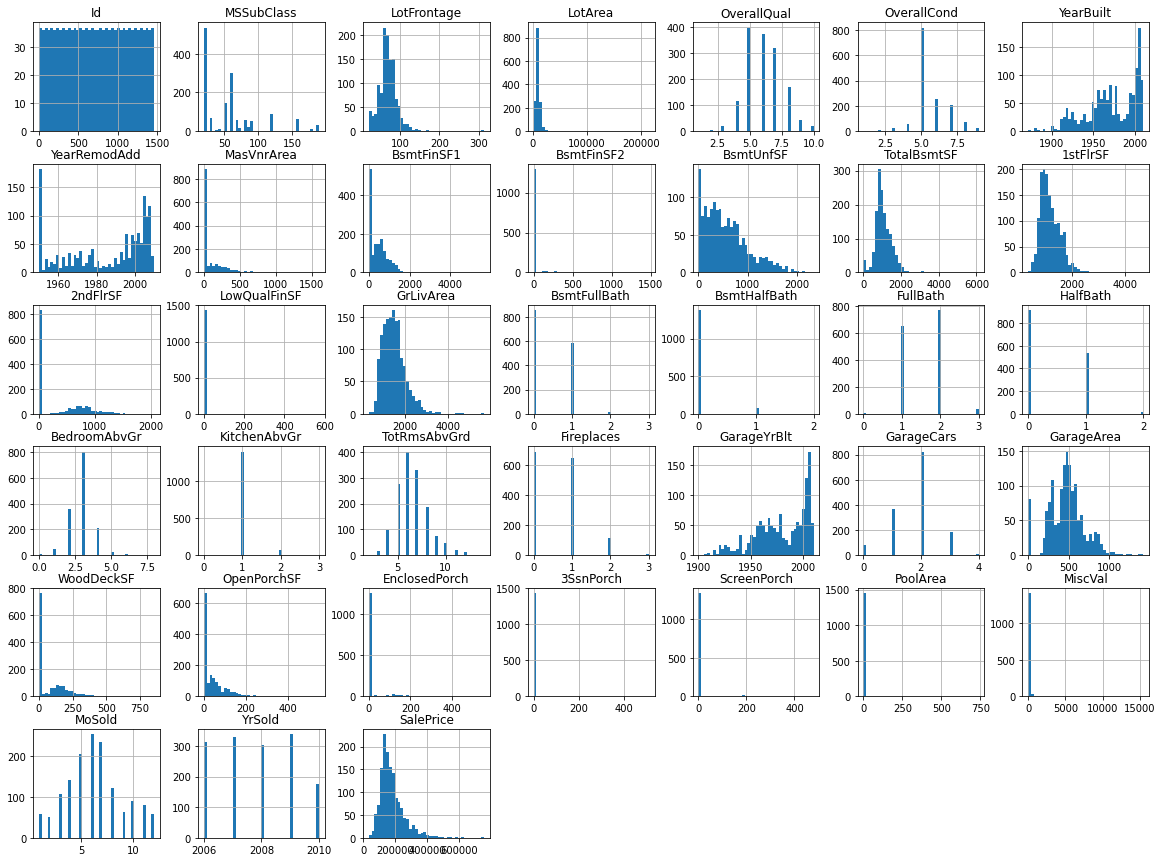

In [57]:
data.hist(layout=(6, 7), figsize=(20, 15), bins=40)
plt.show()

In [14]:
tmp = show_basic_plots(data)

In [15]:
#'dist_cat'
#'dist_mlt_cat'
#'violin_mix'
#'scatter_mix'
#'dist_mlt_mix'

## Numerical

In [16]:
#for i in tmp['dist_num']: 
    #i.show()

- **Id** column must be dropped
- **MSSubClass**, **OverallQual**, **OverallCond** must be recoded as str
- **LotFrontage**, **LotArea**, **MasVnrArea**, **BsmtFinSF1**, **BsmtFinSF2**, **BsmtUnfSF**, **TotalBsmtSF**, **1stFlrSF**, **2stFlrSF**, **GrLivArea**, **GarageArea**, **LotPrice** distributions show big positive skewness => potential outliers
- **LowQualFinSF**, **WoodDeckSF**, **OpenPorchSF**, **EnclosedPorch**, **3SsnPorch**, **ScreenPorch**, **PoolArea**, **MiscVal** have poor right-skewed distributions with significant outliers

------------------------------------------------------------------------------------------------------

- There are 3 significant centers of YearBuilt: 1921-22, 1964-1965, 2002
- The dominant renovation year was 2003
- Most of the garages were built in 1966 and 2002; reminds YearBuilt distribution after 60s
- most of the garages allow for 2 cars; proportion of 1/3 is alomost the same

------------------------------------------------------------------------------------------------------

- Most of the houses has 0 or 1 bath; Half baths is very rare
- Most of the houses has 3 rooms; 2 and 4 are also quite popular, whereas rooms >5 - more like outliers
- Almost all of the houses have 1 kitchen
- In total, more than 10 rooms is an outlier
- Most of the houses have either 0 or 1 fireplaces; some have 2;
- Most of the houses do not have wood deck or open/enclosed/3 season/screen porch

------------------------------------------------------------------------------------------------------

- Most of the houses were sold during June (generally, not in autumn)
- YearSold distribution is almost unimodal


To sum up:
- YearSold, MiscVal, ID are not important
- Decks and porches sq. ft. could be united into some new feature as distributions reminds each other
- Other areas could also be united into some new feature as distributions reminds each other
- Garage Year and Built Year seems to be correlated a lot

Just to have a more detailed look on the distributions:

In [17]:
#for i in tmp['violin_num']: 
    #i.show()

- LotFrontage > 80 are outliers with max=312

- Majority of houses are in average condition, but the number of houses in better condition is bigger than in worser condition
- Majory of houses' quality is above average, which may signify expert's bias during the valuation. Moreover, none ofthe house gained 10. May be considered non-informative due to these facts
- Number of houses built in 1966+1922 = number of houses built in 2002
- Renovation boom occured in 2002, before that - quite unimodal besides 1951
-------------------------------------------------------------------------------------------------------

- 75% of LotArea is below 11k; some accumulation within 18-35k, 46-70 and 4 extra outliers
- MasVnrArea has 2 accumulations: major (below 165) and minor (420-1170) with 2 outliers
- BsmtFinSF1 has 2 groups: around 0 and around 608sq.ft with minor group around 200 and 1 outlier
- BsmtFinSF2 almost equals to 0
- LowQualFinSF almost equals to 0
- BsmtUnfSF is much better - no significant outliers
- TotalDsmtSF, 1stFlrSF, GrLivArea, MasVnrArea are almost perfectly correlated
- 2ndFlrSF is mostly 0, but the other group is 762 sq.ft. No outliers

-------------------------------------------------------------------------------------------------------

- Number of full basement baths mostly 0 or 1, some observations for 2, 3 -- outlier
- basement HalfBath almost equals to zero
- HalfBath almost equals to zero
- FullBath - either 1, 2 or 3; drop the rest
- Bedrooms = 4,5,6 or 8 -- outliers
- Kitchen = 0,2,3 - outliers
- But  something strange with total rooms variable - only 1 outlier (14), with median = 6
- 3 fireplaces - outlier

-------------------------------------------------------------------------------------------------------

- GarageYearBlt more like YearBlt - see comparison
- Garage cars = 4 - outlier
- GarageArea more like grLivArea

-------------------------------------------------------------------------------------------------------

- WoodDeckSF, OpenPorchSF are more alike
- EnclosedPorch, 3SsnPorch, ScreenPorch are much more rare, allmost equals to zero

-------------------------------------------------------------------------------------------------------

- PoolArea - only 7 houses with pools
- MscVal - almost equals to zero
- YrSold is defenitely unimodal
- Sale price distribution looks like total lot sq.feet distribution

Before moving futher, sum up single numerical dstributions:
- Drop rather not important: **YrSold**, **PoolArea**, **MscVal**, **GarageYearBlt**, **BsmtFullBath**,  **BsmtHalfBath**, **HalfBath**, **BsmtFinSF2**, **LowQualFinSF**, **Id**, 
- Unite **EnclosedPorch**, **3SsnPorch**, **ScreenPorch** into **PorchRare**
- Unite **WoodDeckSF**, **OpenPorchSF** into **PorchUsual**
- Unite + remove outliers: **GarageArea**, **grLivArea**, **LotArea**, **TotalDsmtSF**, **1stFlrSF**, **MasVnrArea**
- Remove outliers: **GarageCars**, **Kitchen**, **Fireplaces**, **FullBath**, **Bedroom**. Check correlation with sq.ft. or use **TotRmsAbvGrd** instead
- Keep as it is: **MoSold**, **Sale price**, **BsmtUnfSF**, **BsmtFinSF1**, **TotRmsAbvGrd**, **LotFrontage**, **OverallCond**, **OverallQual**(more factors to study to decide), **YearBuilt**, **YearRemodAdd**, **SalePrice**
- Create one-hot: IsSecondFloor
- Recode as str: **MSSubClass**, **GarageCars**, **Kitchen**, **Fireplaces**, **FullBath**, **Bedroom**, **TotRmsAbvGrd**, **OverallCond**, **OverallQual**

## Numerical (2d)

In [22]:
vars_selected_num = [
    'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'OpenPorchSF', 'WoodDeckSF', 
    'LotArea', 'GarageArea', 'GrLivArea', 'TotalBsmtSF', '1stFlrSF', 'MasVnrArea',
    'GarageCars', 'KitchenAbvGr', 'Fireplaces', 'FullBath', 'BedroomAbvGr',
    'YearRemodAdd', 'MoSold', 'BsmtUnfSF', 'SalePrice', 'BsmtFinSF1', 'TotRmsAbvGrd',
    'LotFrontage', 'OverallCond', 'OverallQual', 'YearBuilt', 
    'PoolQC'
]

In [19]:
plt_lst_num_2d.keys()

dict_keys(['dist_cat', 'dist_mlt_cat', 'dist_num', 'violin_num', 'scatter_num', 'dist_mlt_num', 'violin_mix'])

In [24]:
vars_selected_cor = ['LotArea', 'GrLivArea', 'TotalBsmtSF',
                     'PoolQC']
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['scatter_num']:
    #i.show()

- LotArea and TotalBsmtSF are correlated
- LotArea and GrLivArea are correlated
\
= > keep LotArea only 

In [27]:
vars_selected_cor = ['LotArea', '1stFlrSF',  'MasVnrArea', #'GarageArea',  
                     'PoolQC']
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['scatter_num']:
    #i.show()

- LotArea and 1stFlrSF are correlated
- LotArea and MasVnr are correlated
\
= > keep LotArea only

In [29]:
vars_selected_cor = ['LotArea', 'GarageArea',  
                     'PoolQC']
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['scatter_num']:
    #i.show()

LotArea and GarageArea are correlated
\
= > keep LotArea only

In [49]:
vars_selected_cor = [
    'FullBath',
    'TotRmsAbvGrd'
]
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['scatter_num']:
    #i.show()

In [52]:
vars_selected_cor = [
    'FullBath',
    'TotRmsAbvGrd'
]
plt_lst_num_2d = show_basic_plots(data, vars_subset=vars_selected_cor)
#for i in plt_lst_num_2d['dist_mlt_num']:
    #i.show()

In [53]:
del plt_lst_num_2d

To sum up:
- **LotArea** correlated with all the other areas, **LotFrontage**, 
- **WoodDeckSF** seems to be correlated with all the other porches
- seems not to be important as much: **KitchenAbvGr**, **Fireplaces**, **BedroomAbvGr**, **FullBath**, **MoSold**
- seems to be important: **GarageCars**, **TotRmsAbvGrd**, **YearRemodAdd**, **YearBuilt**, **OverallQual**, **OverallCond**, **BsmtUnfSF**, **WoodDeckSF**, **LotArea**
\
=> out we have 9+1 (MSSubClass) out of 38 vars important 

## Categorical

In [ ]:
for i in tmp['dist_cat']: 
    i.show()